Exercise 3
## 1. Setting things up.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time
import numba
import pylab

# to print plots inline
%matplotlib inline

In [2]:
# Specify parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
z = 1
sigma_z = 0.213
mu = 0.000
rho = 0.7605
sizez = 9
betafirm = (1 / (1 + r))
params = alpha_k, alpha_l, delta, psi, w, r, betafirm

In [3]:
# Set up K-grid
dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2 * kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

# Set up Z-grid
import sys
sys.path.append('../Code')
import ar1_approx as ar1
num_sigma = 4
step = (num_sigma * sigma_z) / (sizez / 2)
pi, zvec = ar1.rouwen(rho, mu, step, sizez)
zvec = np.exp(zvec)

## 2. Coleman-EGM
we would like to use the Euler Equation  
$$1 + c_1(k', k) = \beta[E_{z'|z} \pi_2(z', k') + (1-\delta) - c_2(k'', k')]$$, where 
$$c_1(k', k) = \psi(k'-(1-\delta)k)$$
We would like to:
Guess a policy function k' given grid k;  
Calculate the implied level k using the Euler Equation;  
Invert the function to get the implied k' from k;  
Check for convergence between guess k' and implied k'

In [4]:
def c2(k1, k, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    c2 = (psi / 2) * ((-2)*(k1 - (1 - delta)*k)*(1 - delta)*k - (k1 - (1 - delta)*k)**2)/(k**2)
    return c2

def pi2(k, z, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    pi2 = alpha_k * (alpha_l/w) ** (alpha_l/(1 - alpha_l)) * z ** (1/(1 - alpha_l)) * k **((alpha_k - 1 + alpha_l)/(1 - alpha_l))
    return pi2

In [7]:
egtol = 1e-6
egdist = 7.0
egmaxiter = 3000

k1 = np.repeat(kvec, 9)
k1 = k1.reshape(sizek, sizez) # initial guess of k'
kgrid = np.zeros(sizek) # Initialize grid for k
k2 = np.zeros(sizez)  # initialize grid for k''
egiter = 1

start = time.time()
while egdist > egtol and egiter < egmaxiter:
    Tk = np.copy(k1)
    for i in range(sizez):  # loop over z
        for j in range(sizek):  # loop over k
            for k in range(sizez): # calculate k'' from the guess of k'
                k2[k] = np.interp(k1[j, i], kvec, k1[:, k])
            rhs = np.dot((pi2(k1[j, i], zvec, params) + (1 - delta) - (c2(k2, k1[j, i], params))), pi[:, i])
            kgrid[j] = ( psi * k1[j, i] )/( betafirm * rhs + psi * (1 - delta) - 1)
        k1[:, i] = np.interp(kvec, kgrid, k1[:, i])     
                      
    # iteration for graphing later
    egdist = (np.absolute(k1 - Tk)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    egiter += 1
end = time.time()

if egiter < egmaxiter:
    print('Policy function converged after this many iterations:', egiter)
    print('Time taken for convergence:' + str(end - start))
else:
    print('Policy function did not converge')

Policy function converged after this many iterations: 38
Time taken for convergence:1.7312710285186768


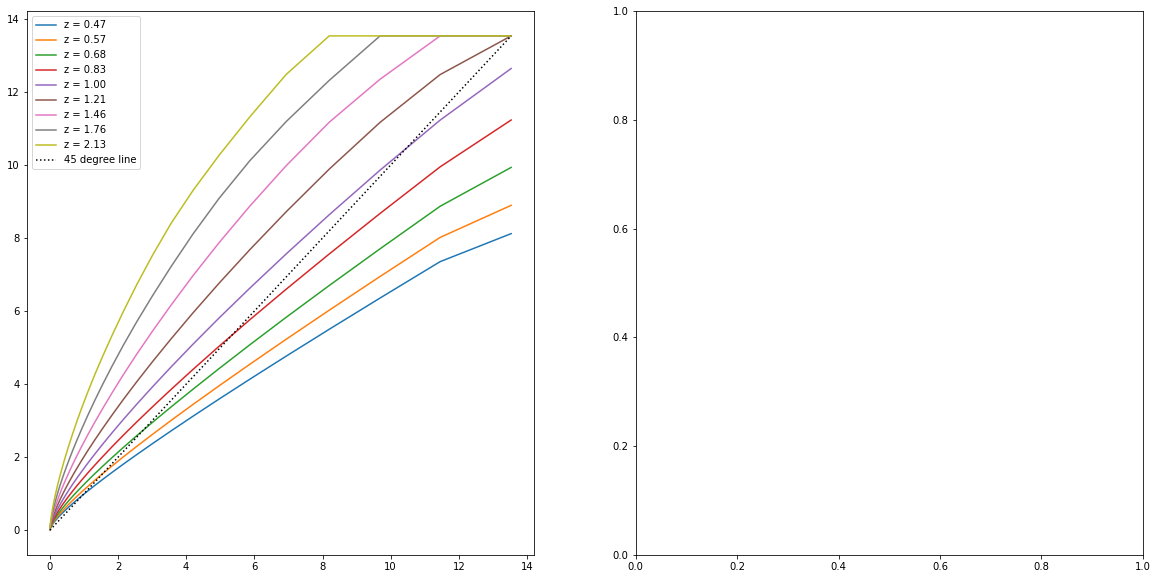

In [11]:
# Value Function
import pickle
v = np.zeros((sizek, sizez))
op = np.zeros((sizek, sizez))
c = np.zeros((sizek, sizez))
for i in range(sizek):
    for j in range(sizez):
        op[j] = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) * ((k ** alpha_k) ** (1 / (1 - alpha_l)))) * z[j] ** (1/(1 - alpha_l))
        c[i, j] = (psi /2) * ((k1[i + 1, j] - (1 - delta) * k1[i, j]) /k1[i, j]) ** 2 * k1[i, j]
        rhs = np.dot(beta * (op[j + 1])
        v[i, j] = op - (1 - delta) * k[i, j] - c + beta

pylab.rcParams['figure.figsize'] = (20, 10)
plt.subplot(121)
for i in range(9):
    plt.plot(kvec, k1[: ,i], label=str('z = ' + "%.2f" %zvec[i]))
plt.plot(kvec, kvec, 'k:', label='45 degree line')
plt.legend()

plt.subplot(122)
ax = pickle.load(open( "Value_Fn", "wb" ))
plt.show()

TypeError: a bytes-like object is required, not 'str'

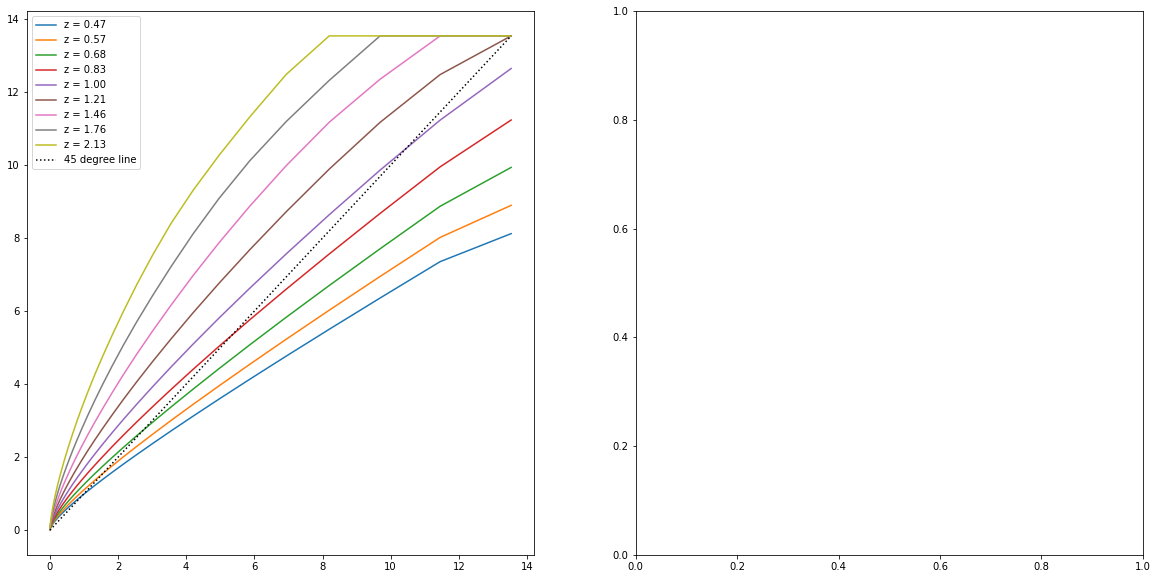

In [23]:
pylab.rcParams['figure.figsize'] = (20, 10)
plt.subplot(121)
for i in range(9):
    plt.plot(kvec, k1[: ,i], label=str('z = ' + "%.2f" %zvec[i]))
plt.plot(kvec, kvec, 'k:', label='45 degree line')
plt.legend()

ax = plt.subplot(122)
ax = pickle.load(open('Value_Fn'))
ax.plot()
plt.show()

(0, 5)

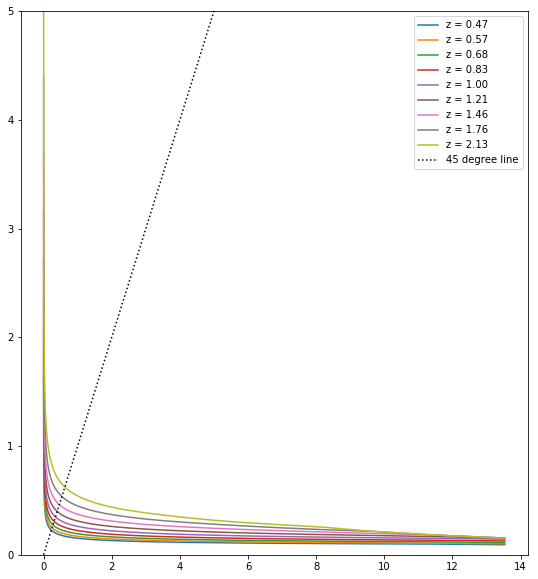

In [15]:
pylab.rcParams['figure.figsize'] = (20, 10)
I = k1 - (1 - delta) * k1
plt.subplot(121)
for i in range(9):
    plt.plot(kvec, I[: ,i]/kvec, label=str('z = ' + "%.2f" %zvec[i]))
plt.plot(kvec, kvec, 'k:', label='45 degree line')
plt.legend()
plt.ylim(0, 5)